# Quantile Trading
### Riya Sheth

riyasheth@uchicago.edu

## Imports

In [249]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import statistics
import statsmodels.api as sm
quandl.ApiConfig.api_key= "dSEK8-iUMxdiDUyrcPdc"
import warnings
from datetime import timedelta
from sklearn import preprocessing
from datetime import datetime
import random
warnings.filterwarnings('ignore')

In [250]:
start_date= pd.Timestamp('2015-01-01')
end_date= pd.Timestamp('2022-01-31')

## FETCHING DATA

The Zacks Fundamentals Overview provides financial information and analysis to individual and institutional investors. This helps us make more informed decisions about our trading strategies. As will be seen in the analysis below, there are numerous financial metrics such as earnings, cashflow, balancesheet that have been organized in the below tables.

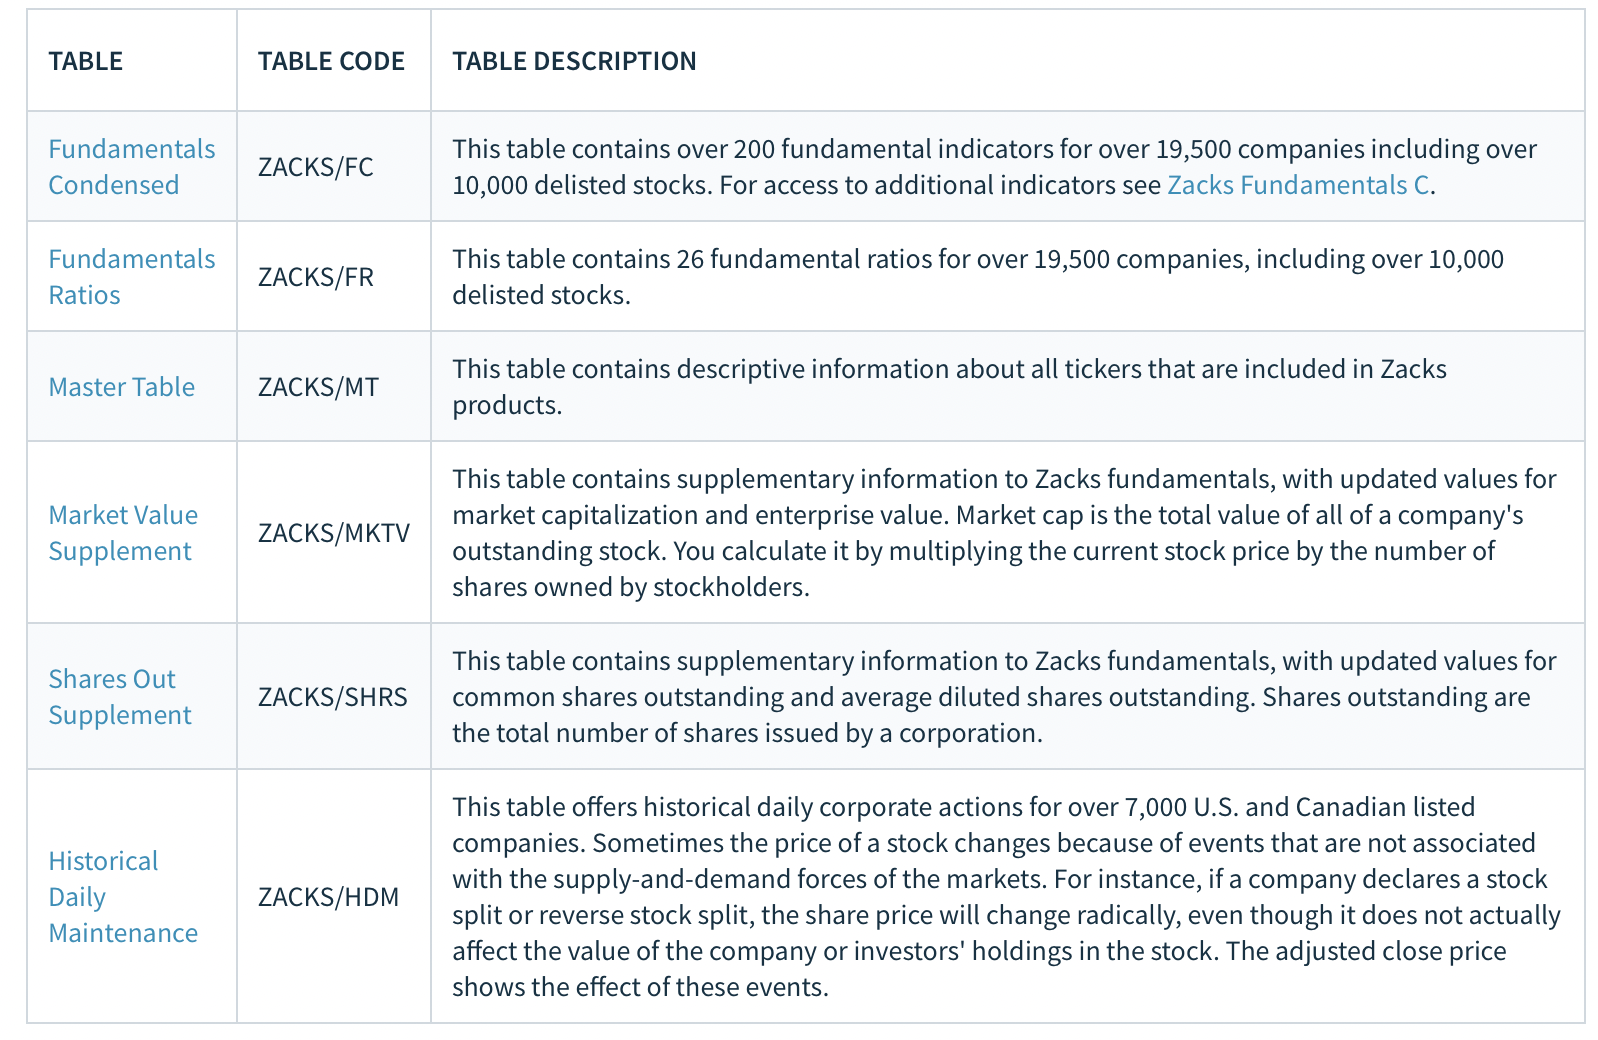

In [251]:
def fetch_data(start_date, end_date):
    
    """
    MT-TABLE
    """
    mt_table= pd.read_csv('ZACKS_MT_2_5c2afb6368dcc3ed48e1a84279323e63.csv')
    mt_table= mt_table[['ticker', 'exchange', 'country_code', 'zacks_x_ind_code', 'zacks_x_sector_code', 'active_ticker_flag']]
    print("Length of MT Table: ", len(mt_table))
    print("Columns of MT Table: ", mt_table.columns)
    
    
    """
    FC-TABLE
    """
    fc_table= pd.read_csv('ZACKS_FC_2_76e4bece47ce87cb8f221f639c7f829b.csv')
    fc_table['per_end_date']= pd.to_datetime(fc_table['per_end_date'])
    fc_table= fc_table[['filing_date', 'tot_revnu', 'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt',
                       'net_lterm_debt', 'net_curr_debt', 'zacks_metrics_ind_code', 'per_type', 'ticker', 
                       'per_end_date', 'exchange']]
    print("FC: Length before filtering out dates: ", len(fc_table))

    fc_df = fc_table.loc[(fc_table['per_end_date'] >= start_date)
                     & (fc_table['per_end_date'] <= end_date)]
    print("FC: Length after filtering out dates: ", len(fc_df))
    print("Columns of FC Table: ", (fc_table.columns))
    
    
    """
    FR-TABLE
    """
    fr_table= pd.read_csv('ZACKS_FR_2_f40c6a304f87d9f492c1f21839d474e2.csv')
    fr_table['per_end_date']= pd.to_datetime(fr_table['per_end_date'])
    fr_table= fr_table[[ 'ret_invst', 'free_cash_flow_per_share', 'per_type', 'ticker',
                        'per_end_date', 'exchange', 'tot_debt_tot_equity']]
    print("FR: Length before filtering out dates: ", len(fr_table))
    fr_df = fr_table.loc[(fr_table['per_end_date'] >= start_date)
                     & (fr_table['per_end_date'] <= end_date)]
    print("FR: Length after filtering out dates: ", len(fr_df))
    print("Columns of FR Table: ", (fr_table.columns))
    
    
    """
    MKTV-TABLE
    """
    mktv_table= pd.read_csv('ZACKS_MKTV_2_ecb7f768974bbdd26964caefe2fd0378.csv')
    mktv_table['per_end_date']= pd.to_datetime(mktv_table['per_end_date'])
    mktv_table= mktv_table[['per_type', 'mkt_val', 'ticker', 'per_end_date']]
    print("MKTV: Length before filtering out dates: ", len(mktv_table))
    mktv_df = mktv_table.loc[(mktv_table['per_end_date'] >= start_date)
                     & (mktv_table['per_end_date'] <= end_date)]
    print("MKTV: Length after filtering out dates: ", len(mktv_df))
    print("Columns of MKTV Table: ", (mktv_table.columns))
    
    
    """
    HDM-TABLE
    """
    hdm_table= pd.read_csv('ZACKS_HDM_2_5035a21ce4e45c8e7fbda0facdcfcb6c.csv')
    
    
    """
    SHRS-TABLE
    """
    shrs_table= pd.read_csv('ZACKS_SHRS_2_99db6fa97ac677f3c0d45a9fa9a70196.csv')
    shrs_table['per_end_date']= pd.to_datetime(shrs_table['per_end_date'])
    print("SHRS: Length before filtering out dates: ", len(shrs_table))
    shrs_table= shrs_table[['shares_out', 'per_type', 'ticker', 'per_end_date']]
    shrs_df = shrs_table.loc[(shrs_table['per_end_date'] >= start_date)
                     & (shrs_table['per_end_date'] <= end_date)]
    print("SHRS: Length after filtering out dates: ", len(shrs_df))
    print("SHRS: ", (shrs_table.columns))
    
    
    #Merging the dataframes
    df_1= fc_df.merge(fr_df, how= 'outer')
    print(len(df_1))
    df_2= shrs_df.merge(mktv_df, how= 'outer')
    print(len(df_2))
    df_3= df_1.merge(df_2, how= 'outer')
    print(len(df_3))
    df_4= df_3.merge(mt_table, how='outer', on='ticker')
    display(df_4.head())
    print("Length of initial dataframe: ", len(df_4))
    print("Initial number of tickers: ", len(set(df_4['ticker'])))
    
    return df_4

## DEFINING THE UNIVERSE

In [252]:
def clean_data(df_4):
    df_4 = df_4[df_4['active_ticker_flag'] == 'Y']
    
    """
    From prioir analysis, we saw that there was always a quarterly data available,
    hence we do not need annual data.
    """
    
    df_4= df_4[df_4['per_type']=='Q']
    
    df_4= df_4[df_4['country_code']=='US']
    
    df_4= df_4[df_4['zacks_x_sector_code']!='13']
    df_4= df_4[df_4['zacks_x_sector_code']!='5']
    
    df_4 = df_4.dropna(subset=['mkt_val', 'tot_debt_tot_equity', 'eps_diluted_net', 'net_lterm_debt'])
    
    print("Length of final dataframe: ", len(df_4))
    print("Final number of tickers: ", len(set(df_4['ticker'])))
    
    return df_4
    

The current data had equities from places apart from the USA, had annual data and had from the automotive, financial or insurance sector. Hence, these along with the rows which had NaN values for the important aspects were removed

In [253]:
def check_the_sec_table(df):
    df= df.reset_index(drop=True)
    new_df= pd.DataFrame(columns= df.columns)
    for i in range(0, len(df)):
        if df['ticker'][i]== 'LLY' and df['per_end_date'][i]== pd.Timestamp('2021-09-30'):
            new_df= new_df.append(df.loc[[i]])
        if df['ticker'][i]== 'LLY' and df['per_end_date'][i]== pd.Timestamp('2021-12-31'):
            new_df= new_df.append(df.loc[[i]])
    new_df= new_df.reset_index(drop=True)
    display(new_df)

In [254]:
%%capture 
#to prevent the printing of the debugging output
df= fetch_data(start_date, end_date)
df= clean_data(df)

In [255]:
check_the_sec_table(df)

filing_date  tot_revnu  eps_diluted_net  basic_net_eps  tot_lterm_debt  \
0  2021-10-27   6772.800             1.22           1.22         15522.4   
1  2022-02-23   7999.902             1.88           1.90         15346.4   

   net_lterm_debt  net_curr_debt  zacks_metrics_ind_code per_type ticker  ...  \
0           505.5           -1.5                    13.0        Q    LLY  ...   
1           505.4           -4.0                    13.0        Q    LLY  ...   

  ret_invst free_cash_flow_per_share  tot_debt_tot_equity  shares_out  \
0    4.7286                   4.4859               2.1480      956.59   
1    7.0450                   6.5274               1.8444      956.59   

     mkt_val  exchange_y  country_code zacks_x_ind_code zacks_x_sector_code  \
0  221020.67        NYSE            US            225.0                 4.0   
1  264229.97        NYSE            US            225.0                 4.0   

   active_ticker_flag  
0                   Y  
1                   Y  

[2 rows x 22 columns]

Since, I did some initial filtering with dates, annual checking and active ticker flag, before checking the values.
all the values were not found but these values precisely matched the values given in the homework pdf.


In [256]:
def fetch_quote_media_price(start_date, end_date):
    dataframe= pd.read_csv('QUOTEMEDIA_PRICES_247f636d651d8ef83d8ca1e756cf5ee4.csv')
    dataframe['date']= pd.to_datetime(dataframe['date'])
    dataframe = dataframe.loc[(dataframe['date'] >= start_date)
                     & (dataframe['date'] <= end_date)]
    return dataframe


Trading Days: I used an online calculator to calculate the number of business/trading days from the start date to the end_date.


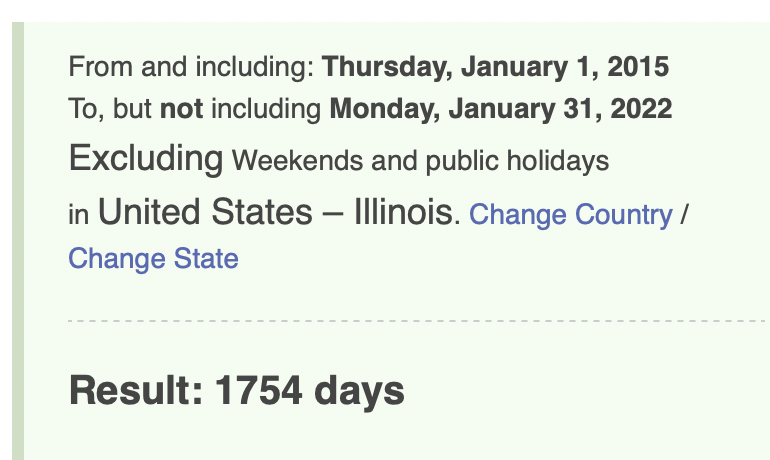

In [257]:
"""
Removing all the tickers that whose end-of-day adjusted closing prices 
are not available , over the entire period Jan 2015 through Jan 2022
"""
def clean_quote_media_price(qmp_df):
    qmp_df= qmp_df.dropna()
    qmp_df= qmp_df.groupby('ticker').filter(lambda x: x.shape[0] >= 1754)
    return qmp_df

In [258]:
qmp_df= fetch_quote_media_price(start_date, end_date)
qmp_df= clean_quote_media_price(qmp_df)

In [259]:
"""
The quotemedia dataframe and the zacks dataframe should have the same tickers.
"""
def interesection_of_tickers(df, qmp_df):
    s1= (set(df['ticker']))
    s2= (set(qmp_df['ticker']))
    ticker_list = list(s1.intersection(s2))
    qmp_df = qmp_df[qmp_df['ticker'].isin(ticker_list)]
    df = df[df['ticker'].isin(ticker_list)]
    return df, qmp_df

In [260]:
"""
Checking if the debt/market cap ratio is greater4 than 0.1 somewhere in the period Jan 2015 through Jan 2022.
This will be checked thoroughly later in the code as well
"""
def check_if_max_debttomarketratio(df):
    max_ratio = df.groupby('ticker')['tot_debt_tot_equity'].max()
    remove_tickers = max_ratio[max_ratio <= 0.1].index
    df = df[~df['ticker'].isin(remove_tickers)]
    return df

In [261]:
df= check_if_max_debttomarketratio(df)

In [262]:
#the specs of my computer did not permit a higher number of tickers to be taken as that resulted in
#the kernel dying while merging
def selection_random_250_tickers(df, qmp_df):
    ticker_list= (set(df['ticker']))
    selected_tickers = random.sample(ticker_list, 250) 
    qmp_df = qmp_df[qmp_df['ticker'].isin(selected_tickers)]
    df = df[df['ticker'].isin(selected_tickers)]
    return df, qmp_df

In [263]:
df, qmp_df= interesection_of_tickers(df, qmp_df)

In [288]:
"""
To check whether I get the same values as the values given in the second table of the pdf.
"""
qmp_df.sort_values([ 'date', 'ticker'], inplace= True)
df.sort_values(['filing_date', 'ticker'], inplace= True)
a = qmp_df[qmp_df['ticker'].isin(['LLY'])]
b= df[df['ticker'].isin(['LLY'])]
a['filing_date']= a['date']

b['filing_date']= pd.to_datetime(df['filing_date'])
data= pd.merge(a, b, on='filing_date', how='outer')
data.ffill(inplace = True)

data.dropna(inplace=True)
data= data.reset_index()
data_lly= data

In [300]:
def check_financial_ratios(data):
    
    dates=[pd.Timestamp('2020-10-29'), pd.Timestamp('2020-12-31'), pd.Timestamp('2021-01-04'),
           pd.Timestamp('2022-01-03')]
    
    pte_list=[]
    roi_list=[]
    dtm_list=[]
    for t in range(0, len(dates)):
        for i in range(0, len(data)):
            if data['filing_date'][i] == dates[t]:
                pte_list.append(data['adj_close'][i]/data['eps_diluted_net'][i])
                ped= data['per_end_date'][i]
                for j in range(0, len(data)):
                    if data['filing_date'][j]== ped:
                        dtm_list.append(data['tot_debt_tot_equity'][i]*data['adj_close'][j]/data['adj_close'][i])
                        mkt_val_scaled= data['mkt_val'][i] *data['adj_close'][i]/data['adj_close'][j]
                        roi= data['ret_invst'][i]*(data['net_lterm_debt'][i]+ data['mkt_val'][i])/(data['net_lterm_debt'][i]+ mkt_val_scaled)
                        roi_list.append(roi)
                        break

                        
    new_df= pd.DataFrame()
    new_df['Date']= dates
    new_df['Debt_to_Mkt_Cap']= dtm_list
    new_df['Return_on_Investment']= roi_list
    new_df['Price_to_Earnings']= pte_list
    
    display(new_df)
    

In [301]:
check_financial_ratios(data_lly)

Date  Debt_to_Mkt_Cap  Return_on_Investment  Price_to_Earnings
0 2020-10-29         3.782411              6.317094          96.358352
1 2020-12-31         2.953930              4.948484         123.383705
2 2021-01-04         3.013544              5.047243         120.942923
3 2022-01-03         1.820469              4.008969         219.754660

The values above matched the given values in the table. A random selection of 4 was selected to match

In [302]:
df, qmp_df= selection_random_250_tickers(df, qmp_df)

In [303]:
def merge_dataframes(a, b):
    a['filing_date']= a['date']
    b['filing_date']= pd.to_datetime(df['filing_date'])
    data= pd.merge(a, b, on='filing_date', how='outer')
    data= data.sort_values(by=['ticker_x', 'date'])
    data.ffill(inplace = True)
    data.bfill(inplace = True)
    return data

In [304]:
data= merge_dataframes(qmp_df, df)

In [305]:
def add_per_end_date_price_column(data):
 
    new_list= [data['adj_close'][0]]
    constant= data['adj_close'][0]
    for i in range(1, len(data)):
        if (data['per_end_date'][i]==data['per_end_date'][i-1] and data['ticker_x'][i]==data['ticker_x'][i-1]):
            new_list.append(constant)
        else:
            constant= data['adj_close'][i]
            new_list.append(constant)
            
    return new_list

In [306]:
data= data.sort_values(by=['ticker_x', 'date'])
nl= add_per_end_date_price_column(data)
data['per_end_date_price']= nl

In [307]:
def add_financial_ratios(df):
    df= df.assign(pte = df['adj_close']/df['eps_diluted_net'])
    df= df.assign(dtm= df['tot_debt_tot_equity']*df['per_end_date_price']/df['adj_close'])
    df= df.assign(roi= df['ret_invst']*(df['net_lterm_debt']+ df['mkt_val'])/(df['net_lterm_debt']+ df['mkt_val']*(df['adj_close']/df['per_end_date_price'])))
    return df

In [310]:
data= data.reset_index(drop=True)
data= add_financial_ratios(data)
display(data[['ticker_x', 'date', 'pte', 'dtm', 'roi']].head(10))
print("Dataframe Shape: ", data.shape)

ticker_x       date        pte       dtm       roi
0     ABBV 2015-01-02  66.415069  0.412000  4.138600
1     ABBV 2015-01-05  65.165187  0.347193  3.494606
2     ABBV 2015-01-06  64.842637  0.328884  3.312195
3     ABBV 2015-01-07  67.463356  0.610486  6.095034
4     ABBV 2015-01-08  68.168934  0.217314  2.196166
5     ABBV 2015-01-09  66.304192  0.350735  3.529865
6     ABBV 2015-01-12  66.284033  0.080499  0.816993
7     ABBV 2015-01-13  64.389051  0.032359  0.328906
8     ABBV 2015-01-14  64.703937  0.488093  4.891464
9     ABBV 2015-01-15  63.881171  0.397228  3.992037

Dataframe Shape:  (1597783, 40)


The below method does additional filtering based on the conditions debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2015 through Jan 2022 and has feasible calculation of the ratios specified below , over the en- tire period Jan 2015 through Jan 2022, including for at least one PER END DATE no more than one year old. Debt ratio of zero is OK

In [315]:
def filter_data(data):
    data.dropna(inplace=True)
    max_ratio = data.groupby('ticker_x')['dtm'].max()
    remove_tickers = max_ratio[max_ratio <= 0.1].index
    data = data[~data['ticker_x'].isin(remove_tickers)]
    return data

In [316]:
data= filter_data(data)

In [319]:
display(data.head())
display(data.describe())

ticker_x       date   open   high    low  close     volume  dividend  split  \
0     ABBV 2015-01-02  65.62  66.40  65.49  65.89  5087291.0       0.0    1.0   
1     ABBV 2015-01-05  65.50  66.10  63.88  64.65  8007433.0       0.0    1.0   
2     ABBV 2015-01-06  65.62  65.75  63.70  64.33  5488071.0       0.0    1.0   
3     ABBV 2015-01-07  64.57  67.05  64.48  66.93  8283083.0       0.0    1.0   
4     ABBV 2015-01-08  68.16  68.29  67.42  67.63  7945920.0       0.0    1.0   

    adj_open  ...  mkt_val  exchange_y  country_code  zacks_x_ind_code  \
0  46.300042  ...  4955.14        NYSE            US               3.0   
1  46.215373  ...  4955.14        NYSE            US               3.0   
2  46.300042  ...  4955.14        NYSE            US               3.0   
3  45.559185  ...  4955.14        NYSE            US               3.0   
4  48.092211  ...  4955.14        NYSE            US               3.0   

  zacks_x_sector_code  active_ticker_flag  per_end_date_price        pte  \
0                11.0                   Y           46.490548  66.415069   
1                11.0                   Y           38.440397  65.165187   
2                11.0                   Y           36.232993  64.842637   
3                11.0                   Y           69.975229  67.463356   
4                11.0                   Y           25.169560  68.168934   

        dtm       roi  
0  0.412000  4.138600  
1  0.347193  3.494606  
2  0.328884  3.312195  
3  0.610486  6.095034  
4  0.217314  2.196166  

[5 rows x 40 columns]

open          high           low         close        volume  \
count  1.597783e+06  1.597783e+06  1.597783e+06  1.597783e+06  1.597783e+06   
mean   5.426972e+01  5.503010e+01  5.351235e+01  5.429246e+01  1.329902e+06   
std    7.769237e+01  7.865571e+01  7.672091e+01  7.772349e+01  4.749832e+06   
min    3.780000e-02  3.950000e-02  3.690000e-02  3.800000e-02  0.000000e+00   
25%    1.313000e+01  1.336000e+01  1.289000e+01  1.313000e+01  9.082900e+04   
50%    3.075000e+01  3.125000e+01  3.024000e+01  3.077000e+01  3.350360e+05   
75%    6.447000e+01  6.531000e+01  6.360000e+01  6.453000e+01  1.044007e+06   
max    1.088000e+03  1.119540e+03  1.082720e+03  1.092340e+03  4.906276e+08   

           dividend         split      adj_open      adj_high       adj_low  \
count  1.597783e+06  1.597783e+06  1.597783e+06  1.597783e+06  1.597783e+06   
mean   4.258241e-03  9.998703e-01  1.105207e+05  1.148766e+05  1.047271e+05   
std    3.987155e-01  1.244243e-02  2.910284e+06  3.016237e+06  2.768412e+06   
min    0.000000e+00  2.222222e-02  5.600000e-02  6.000000e-02  4.600000e-02   
25%    0.000000e+00  1.000000e+00  1.410000e+01  1.438000e+01  1.382289e+01   
50%    0.000000e+00  1.000000e+00  3.028078e+01  3.086654e+01  2.973343e+01   
75%    0.000000e+00  1.000000e+00  6.206705e+01  6.300000e+01  6.111745e+01   
max    4.784358e+02  4.000000e+00  1.701000e+08  1.864721e+08  1.449000e+08   

       ...  free_cash_flow_per_share  tot_debt_tot_equity    shares_out  \
count  ...              1.597783e+06         1.597783e+06  1.597783e+06   
mean   ...             -1.133596e+00         1.934806e+00  1.540121e+02   
std    ...              4.567090e+01         7.228487e+01  4.288458e+02   
min    ...             -2.586425e+03        -1.103100e+03  0.000000e+00   
25%    ...             -2.034000e-01         3.030000e-01  1.647000e+01   
50%    ...              7.333000e-01         7.035000e-01  4.309000e+01   
75%    ...              2.164400e+00         1.345600e+00  1.212100e+02   
max    ...              1.378883e+02         5.579360e+03  4.368490e+03   

            mkt_val  zacks_x_ind_code  zacks_x_sector_code  \
count  1.597783e+06      1.597783e+06         1.597783e+06   
mean   9.698106e+03      1.295744e+02         9.946026e+00   
std    2.627308e+04      8.871661e+01         4.261103e+00   
min    2.900000e-01      1.000000e+00         1.000000e+00   
25%    2.666100e+02      5.000000e+01         7.000000e+00   
50%    1.392860e+03      1.110000e+02         1.200000e+01   
75%    5.834100e+03      2.050000e+02         1.300000e+01   
max    2.560832e+05      2.880000e+02         1.600000e+01   

       per_end_date_price           pte           dtm           roi  
count        1.597783e+06  1.597783e+06  1.597783e+06  1.597783e+06  
mean         1.093960e+05           inf  7.532259e+04  2.310922e+00  
std          2.881877e+06           NaN  3.806275e+07  3.700716e+04  
min          6.000000e-02 -3.132421e+10 -3.305118e+09 -2.093297e+07  
25%          1.409778e+01 -2.918195e+00  1.187702e-01 -1.771485e-01  
50%          3.029000e+01  2.631565e+01  6.059029e-01  6.276517e-01  
75%          6.210386e+01  1.093326e+02  2.577494e+00  3.558954e+00  
max          1.454040e+08           inf  3.326904e+10  2.230373e+07  

[8 rows x 30 columns]

The above is the final data obtained after the data assembly and defining the ratios

## ANALYSIS

Using the data above we create a quantile trading strategy. A quantile trading strategy divides the data into quantiles based on certain rules and then those quantiles are used to determine whther one should enter or exit the market

### quantile strategy using weekly price to earnings ratio

In [426]:
#initial_capital= 10*gross notional

def weekly_pte(data, n_quantiles):
    weekly_pnl=[]
    data = data.set_index("date")
    weekly_data = data.resample("W").mean()
    
    weekly_data["quantile"] = pd.qcut(weekly_data["pte"], n_quantiles, labels=False)
    #display(weekly_data.head())
    buy_price= None
    
    pnl=0
    for i in range(50, len(weekly_data)):
        pnl, buy_price= trade(weekly_data["quantile"].iloc[i], weekly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        weekly_pnl.append(pnl)
    print("Cumulative PNL: ", pnl)
    plt.plot(weekly_data.index[50:], weekly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Weekly Cumulative PnL based on Decisions made by Price to Earnings')
    plt.figure(figsize=(10, 10))
    plt.show()


Cumulative PNL:  1399.7970768237064


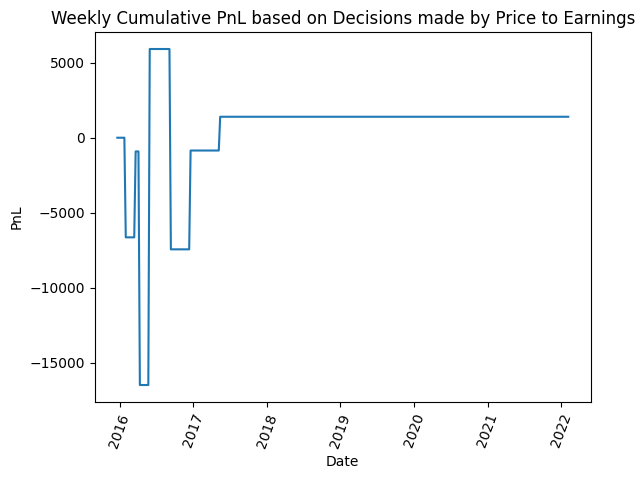

<Figure size 1000x1000 with 0 Axes>

In [427]:
weekly_pte(data, 10)

### quantile strategy using monthly price to earnings ratio

In [428]:
def monthly_pte(data, n_quantiles):
    monthly_pnl=[]
    data = data.set_index("date")
    monthly_data = data.resample("M").mean()
    monthly_data["quantile"] = pd.qcut(monthly_data["pte"], n_quantiles, labels=False)
    
    
    pnl=0
    buy_price=None
    for i in range(len(monthly_data)):
        pnl, buy_price= trade(monthly_data["quantile"].iloc[i], monthly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        monthly_pnl.append(pnl)
    print("Cumulative PNL: ", pnl)
    plt.plot(monthly_data.index, monthly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Monthly Cumulative PnL based on Decisions made by Price to Earnings')
    plt.figure(figsize=(10, 10))
    plt.show()


Cumulative PNL:  -6665.641539392811


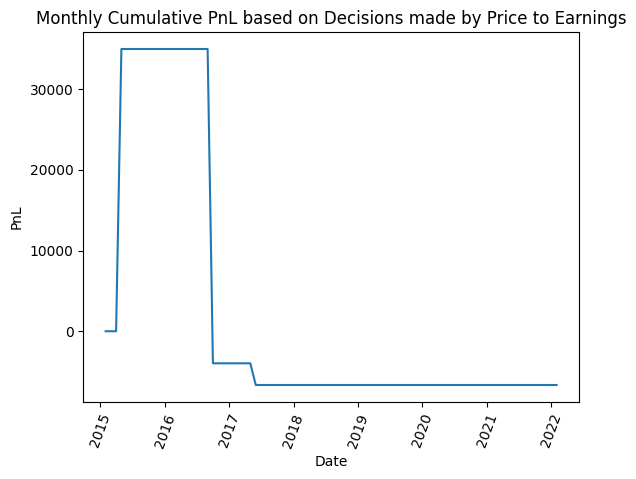

<Figure size 1000x1000 with 0 Axes>

In [429]:
monthly_pte(data, 10)

### Impact of P/E Ratio
If a stock has a low P/E ratio, it may be considered undervalued and a buy signal may be generated. Conversely, if a stock has a high P/E ratio, it may be considered overvalued and a sell signal may be generated.

### Event Analysis
As we have seen in both the cases above, the year 2016 was not profitable. apart from the fact that the market was volatile there could have been other events which affected this like the brexit or the us elections.


### Why did monthly do better than weekly?
This could be due to the following reasons, monthly data has less noise. Monthly data also has less trades and as we have seen in the weekly case, the trades were not very profitable, hence it was better that fewer trades happened in the monthly data. The monthly case may also identify long-term trends that the weekly data was unable to identify

### quantile strategy using weekly debt to market ratio

In [430]:
def weekly_dtm(data, n_quantiles):
    data = data.set_index("date")
    weekly_data = data.resample("W").mean()
    weekly_pnl=[]
    weekly_data["quantile"] = pd.qcut(weekly_data["dtm"], n_quantiles, labels=False)
    display(weekly_data.head())
    
    pnl=0
    buy_price= None
    for i in range(len(weekly_data)):
        pnl, buy_price= trade2(weekly_data["quantile"].iloc[i], weekly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        weekly_pnl.append(pnl)
    print(pnl)
    plt.plot(weekly_data.index, weekly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Weekly Cumulative PnL based on Decisions made by Debt to Market Ratio')
    plt.figure(figsize=(10, 10))
    plt.show()



open       high        low      close        volume  \
date                                                                   
2015-01-04  44.753501  45.115239  43.854126  44.471796  8.321251e+05   
2015-01-11  44.008802  44.513184  43.275608  43.838618  1.157864e+06   
2015-01-18  43.726719  44.334520  43.116451  43.704853  1.142792e+06   
2015-01-25  44.096755  44.674934  43.512759  44.215918  1.051274e+06   
2015-02-01  44.693646  45.301641  44.043049  44.693726  1.218424e+06   

            dividend  split      adj_open      adj_high        adj_low  ...  \
date                                                                    ...   
2015-01-04  0.001647    1.0  9.397343e+05  9.489225e+05  845479.903967  ...   
2015-01-11  0.000548    1.0  9.337528e+05  9.801642e+05  896823.933550  ...   
2015-01-18  0.001912    1.0  1.004403e+06  1.053990e+06  956033.991881  ...   
2015-01-25  0.000250    1.0  9.528829e+05  9.692916e+05  923790.557484  ...   
2015-02-01  0.004127    1.0  8.803505e+05  9.184014e+05  845358.665126  ...   

            tot_debt_tot_equity  shares_out        mkt_val  zacks_x_ind_code  \
date                                                                           
2015-01-04            -3.896228  581.045663  116918.056627          2.004016   
2015-01-11            -3.896284  581.051922  116919.502466          2.004003   
2015-01-18            -3.896298  581.053480  116919.862480          2.004000   
2015-01-25            -3.896298  581.053480  116919.862480          2.004000   
2015-02-01            -3.896298  581.053480  116919.862480          2.004000   

            zacks_x_sector_code  per_end_date_price            pte  \
date                                                                 
2015-01-04                 11.0           59.369418 -132502.801827   
2015-01-11                 11.0       100043.179491 -135050.184973   
2015-01-18                 11.0        30723.317210 -140893.044714   
2015-01-25                 11.0        26333.917671 -133069.402345   
2015-02-01                 11.0        70077.436357 -123068.759031   

                     dtm        roi  quantile  
date                                           
2015-01-04    -12.575573  87.326028         1  
2015-01-11 -51944.081252 -13.419166         0  
2015-01-18   -457.497083  77.128758         0  
2015-01-25  -3648.021300  44.908169         0  
2015-02-01  -7681.561841   2.684993         0  

[5 rows x 31 columns]

-355096.0573636299


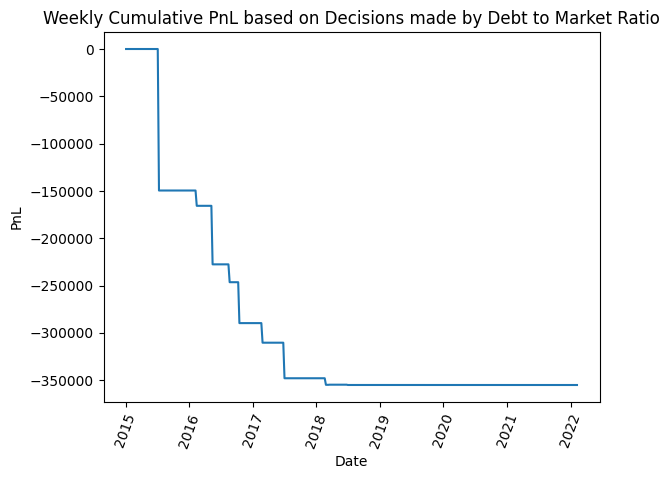

<Figure size 1000x1000 with 0 Axes>

In [431]:
weekly_dtm(data, 10)

### monthly quantile strategy using weekly debt to market ratio

In [432]:
def monthly_dtm(data, n_quantiles):
    data = data.set_index("date")
    monthly_pnl=[]
    monthly_data = data.resample("M").mean()
    monthly_data["quantile"] = pd.qcut(monthly_data["dtm"], n_quantiles, labels=False)
    display(monthly_data.head())
    
    pnl=0
    buy_price= None
    for i in range(len(monthly_data)):
        pnl, buy_price= trade2(monthly_data["quantile"].iloc[i], monthly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        monthly_pnl.append(pnl)
    print("Cumulative PNL: ", pnl)
    plt.plot(monthly_data.index, monthly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Monthly Cumulative PnL based on Decisions made by Debt to Market')
    plt.figure(figsize=(10, 10))
    plt.show()

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  tot_debt_tot_equity  shares_out        mkt_val  \
date        ...                                                   
2015-01-31  ...            -3.896291  581.052701  116919.682545   
2015-02-28  ...            -3.896298  581.053480  116919.862480   
2015-03-31  ...            -3.896298  581.053480  116919.862480   
2015-04-30  ...            -0.840640  419.656329   38197.197959   
2015-05-31  ...             0.943835   95.191973    5224.664422   

            zacks_x_ind_code  zacks_x_sector_code  per_end_date_price  \
date                                                                    
2015-01-31          2.004002            11.000000        55482.907923   
2015-02-28          2.004000            11.000000        91528.573862   
2015-03-31          2.004000            11.000000       184414.427947   
2015-04-30        107.593481             9.981481       133366.747180   
2015-05-31        129.877551             9.959184       120547.741419   

                     pte            dtm        roi  quantile  
date                                                          
2015-01-31 -1.329917e+05  -15746.925521  29.943777         0  
2015-02-28 -1.268610e+05   -9157.083108  -8.614741         0  
2015-03-31 -1.054865e+05  -12066.251659  -0.164466         0  
2015-04-30  4.864894e+06  113881.861398  32.835947         9  
2015-05-31           NaN   11374.062035 -38.248839         6  

[5 rows x 31 columns]

Cumulative PNL:  -271502.8080552388


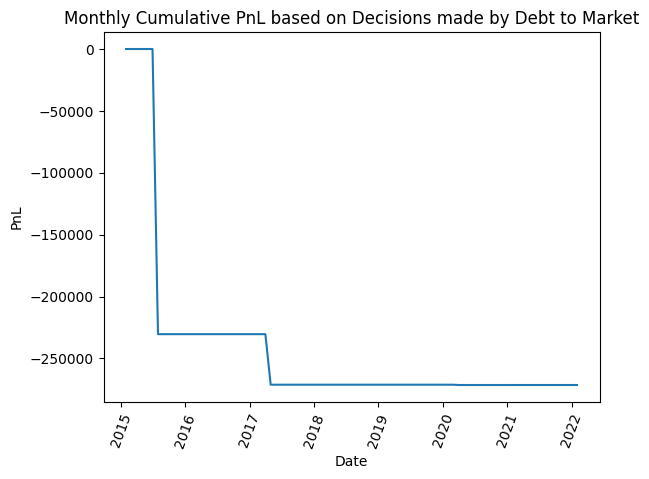

<Figure size 1000x1000 with 0 Axes>

In [433]:
monthly_dtm(data, 10)

### Why the trade based on debt to market ratio did not go well?
This could be because it is giving an incomplete picture of the trading environment when used alone. It could be a result of overfitting or not o much relevance. This needs to be investigated further to give a better reasoning.

### quantile strategy using weekly return on investment 

In [434]:
#initial_capital= 10*gross notional

def weekly_roi(data, n_quantiles):
    weekly_pnl=[]
    data = data.set_index("date")
    weekly_data = data.resample("W").mean()
    
    weekly_data["quantile"] = pd.qcut(weekly_data["roi"], n_quantiles, labels=False)
    #display(weekly_data.head())
    buy_price= None
    
    pnl=0
    for i in range(0, len(weekly_data)):
        pnl, buy_price= trade(weekly_data["quantile"].iloc[i], weekly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        weekly_pnl.append(pnl)
    print("Cumulative PNL: ", pnl)
    plt.plot(weekly_data.index, weekly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Weekly Cumulative PnL based on Decisions made by Return on Investment')
    plt.figure(figsize=(10, 10))
    plt.show()

Cumulative PNL:  -146370.8108173147


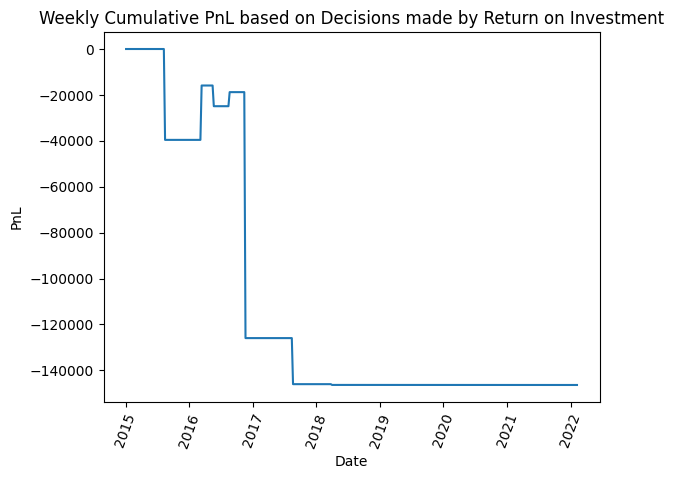

<Figure size 1000x1000 with 0 Axes>

In [435]:
weekly_roi(data, 10)

### quantile strategy using monthly return on investment 

In [436]:
def monthly_roi(data, n_quantiles):
    monthly_pnl=[]
    data = data.set_index("date")
    monthly_data = data.resample("M").mean()
    monthly_data["quantile"] = pd.qcut(monthly_data["roi"], n_quantiles, labels=False)
    
    
    pnl=0
    buy_price=None
    for i in range(len(monthly_data)):
        pnl, buy_price= trade(monthly_data["quantile"].iloc[i], monthly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        monthly_pnl.append(pnl)
    print("Cumulative PNL: ", pnl)
    plt.plot(monthly_data.index, monthly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Monthly Cumulative PnL based on Decisions made by Return on Investment')
    plt.figure(figsize=(10, 10))
    plt.show()

Cumulative PNL:  23801.251307188344


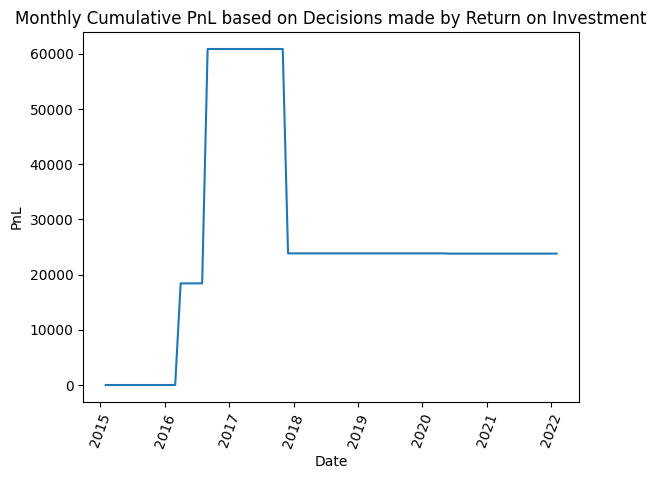

<Figure size 1000x1000 with 0 Axes>

In [437]:
monthly_roi(data, 10)

The reasons than the monthly strategy did better than the weekly strategy has been explained before.

Like price_to_earnings  if a stock has a high ROI, it may be considered undervalued and a buy signal may be generated. Conversely, if a stock has a low ROI, it may be considered overvalued and a sell signal may be generated. 

<AxesSubplot: >

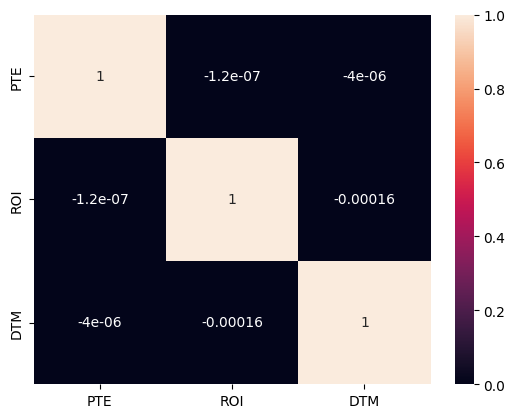

In [438]:
correlation_df= pd.DataFrame()
correlation_df['PTE']= data['pte']
correlation_df['ROI']= data['roi']
correlation_df['DTM']= data['dtm']
corr_matrix = correlation_df.corr()
sns.heatmap(corr_matrix, annot=True)

They are not correlated to each other and hence it makes sense to use all of them. We use monthly below because we have seen than monthly gives better results than weekly. So we use a non-tirival combination of the three ratios, we know that debt to market ratio works in the opposite way as compared to the other two ratios and was not as effective.
a * debt to market + b * return on investment + c * price to earnings ratio.

Here, a b and c can be hyperoptimized but due to the lack of computational powers

a = -0.2 (because it works in the opposite way) b= 3, c=1

has been taken as an informed guess.

In [439]:
def non_trivial_combination_of_ratios_monthly(data, n_quantiles):
    data = data.set_index("date")
    monthly_pnl=[]
    monthly_data = data.resample("M").mean()
    monthly_data= monthly_data.assign(new = -0.2* monthly_data['dtm']+ 3*monthly_data['roi']+ monthly_data['pte'])
    monthly_data["quantile"] = pd.qcut(monthly_data["dtm"], n_quantiles, labels=False)
    display(monthly_data.head())
    
    pnl=0
    buy_price= None
    for i in range(len(monthly_data)):
        pnl, buy_price= trade(monthly_data["quantile"].iloc[i], monthly_data["adj_close"].iloc[i], pnl, n_quantiles, buy_price)
        monthly_pnl.append(pnl)
    
    print("Cumulative PNL: ", pnl)
    plt.plot(monthly_data.index, monthly_pnl)
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('Monthly Cumulative PnL based on Decisions made by Debt to Market')
    plt.figure(figsize=(10, 10))
    plt.show()
    
    return pnl

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         9  
2015-05-31   11374.062035 -38.248839           NaN         6  

[5 rows x 32 columns]

Cumulative PNL:  129720.03698653597


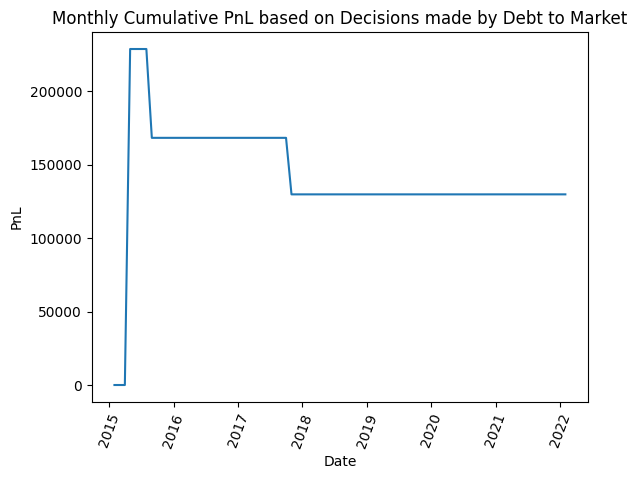

<Figure size 1000x1000 with 0 Axes>

129720.03698653597

In [440]:
non_trivial_combination_of_ratios_monthly(data, 10)

### The reason this makes a profit
This makes use of all the financial information stored in all the three ratios and hence is a more informed trading strategy.

In [352]:
def trade(current_quantile, current_price, pnl, n_quantiles, buy_price):
    if current_quantile == 0:
        # Buy
        buy_price = current_price
    elif current_quantile ==  n_quantiles-1:
        # Sell
        if buy_price is not None:
            pnl += current_price - buy_price
            buy_price = None
    else:
        # Do nothing
        pass
    return pnl, buy_price

In [394]:
def trade2(current_quantile, current_price, pnl, n_quantiles, buy_price):
    if current_quantile == n_quantiles-1:
        # Buy
        buy_price = current_price
    elif current_quantile ==  0:
        # Sell
        if buy_price is not None:
            pnl += current_price - buy_price
            buy_price = None
    else:
        # Do nothing
        pass
    return pnl, buy_price

### The Optimization of Quantiles
This is to see if another strategy except the quantile strategy works better.

In [424]:
def optimization_quantiles():
    n_quantile_list= [2, 3, 4, 6, 8, 9, 10, 15, 20]
    pnl_list=[]
    for i in range(0, len(n_quantile_list)):
        pnl_list.append(non_trivial_combination_of_ratios_monthly(data, n_quantile_list[i]))
    plt.plot(n_quantile_list, pnl_list)
    plt.xticks(rotation=70)
    plt.xlabel('N Quantiles')
    plt.ylabel('PnL')
    plt.title('Optimization using N Quantiles')
    plt.figure(figsize=(10, 10))
    plt.show()

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         1  
2015-05-31   11374.062035 -38.248839           NaN         1  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         2  
2015-05-31   11374.062035 -38.248839           NaN         2  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         3  
2015-05-31   11374.062035 -38.248839           NaN         2  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         5  
2015-05-31   11374.062035 -38.248839           NaN         4  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         7  
2015-05-31   11374.062035 -38.248839           NaN         5  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         8  
2015-05-31   11374.062035 -38.248839           NaN         6  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06         9  
2015-05-31   11374.062035 -38.248839           NaN         6  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         0  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06        14  
2015-05-31   11374.062035 -38.248839           NaN        10  

[5 rows x 32 columns]

open       high        low      close        volume  \
date                                                                   
2015-01-31  44.164231  44.728051  43.504011  44.126061  1.131686e+06   
2015-02-28  46.171605  46.749637  45.658533  46.293723  1.170787e+06   
2015-03-31  47.770430  48.347966  47.257554  47.832795  1.087715e+06   
2015-04-30  48.117493  48.627479  47.443496  47.976734  1.169814e+06   
2015-05-31  47.335660  47.900967  46.810715  47.362250  1.049397e+06   

            dividend     split       adj_open      adj_high        adj_low  \
date                                                                         
2015-01-31  0.001780  1.000000  942192.022328  9.794494e+05  901598.432940   
2015-02-28  0.003518  0.999860  907396.467799  9.356808e+05  866903.563078   
2015-03-31  0.003182  0.999836  756224.007130  7.799869e+05  715263.726941   
2015-04-30  0.002924  1.000000  964503.479619  1.025757e+06  927307.007934   
2015-05-31  0.003053  1.000000  918964.134316  9.428358e+05  874509.777319   

            ...  shares_out        mkt_val  zacks_x_ind_code  \
date        ...                                                
2015-01-31  ...  581.052701  116919.682545          2.004002   
2015-02-28  ...  581.053480  116919.862480          2.004000   
2015-03-31  ...  581.053480  116919.862480          2.004000   
2015-04-30  ...  419.656329   38197.197959        107.593481   
2015-05-31  ...   95.191973    5224.664422        129.877551   

            zacks_x_sector_code  per_end_date_price           pte  \
date                                                                
2015-01-31            11.000000        55482.907923 -1.329917e+05   
2015-02-28            11.000000        91528.573862 -1.268610e+05   
2015-03-31            11.000000       184414.427947 -1.054865e+05   
2015-04-30             9.981481       133366.747180  4.864894e+06   
2015-05-31             9.959184       120547.741419           NaN   

                      dtm        roi           new  quantile  
date                                                          
2015-01-31  -15746.925521  29.943777 -1.297525e+05         0  
2015-02-28   -9157.083108  -8.614741 -1.250554e+05         1  
2015-03-31  -12066.251659  -0.164466 -1.030738e+05         0  
2015-04-30  113881.861398  32.835947  4.842217e+06        19  
2015-05-31   11374.062035 -38.248839           NaN        13  

[5 rows x 32 columns]

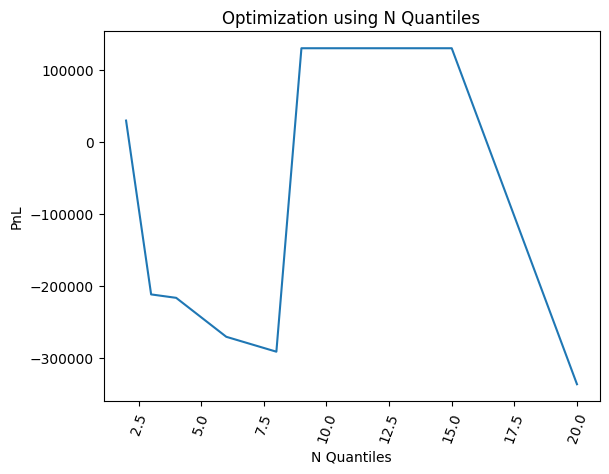

<Figure size 1000x1000 with 0 Axes>

In [425]:
optimization_quantiles()

The number of quantiles used will affect how finely or broadly the market conditions are divided, which in turn affects the number of trades that are generated and the potential returns of the strategy.

If a strategy uses a large number of quantiles, it will generate more trades, but the trades will be based on more specific market conditions. This can lead to higher returns, but it also increases the risk of the strategy, as more trades means more potential for losses.

On the other hand, if a strategy uses a smaller number of quantiles, it will generate fewer trades, but the trades will be based on more general market conditions. This can lead to lower returns, but it also reduces the risk of the strategy, as fewer trades means less potential for losses.

Hence, reaching a sweet spot is the way to go and further optimization methods would be useful.

This also shows that the strategy works best in the decile case

### Strategy in General

### When is the strategy useful?
As learnt in portfolio theory, the quantile trading strategy is a very useful trick used to diversify the portfolio or minimize the risk. 

### What are the pros of the strategy?
Diversification

Risk Management

Returns: if the market is in favour a profit can be made from two sides, from the lower deciles and from the top deciles.

### What are the cons of the strategy?
As seen in the analysis above the quantile trading strategy hasnt always guarnteed profit and this is without the added expense of transaction costs which would render this strategy even worse. The quantile trading strategy is highly dependent on the market and a sudden change in the market or volatility would render this straetgy not great.

### How can the strategy be improved?
This strategy could be improved with some advanced tecnhiques such as sentiment analysis which would account for the economic events. Using advanced techniques such as machine learning and also revieing the quantiles more often would help better the performance of the strategy